# Разработка A/B-тестирования и анализ результатов

Существует компания, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

<span style="font-size: 20px;">**Описание данных:**</span>

Мы будем работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;
- `session_id` — идентификатор сессии в приложении;
- `session_date` — дата сессии;
- `session_start_ts` — дата и время начала сессии;
- `install_date` — дата установки приложения;
- `session_number` — порядковый номер сессии для конкретного пользователя;
- `registration_flag` — является ли пользователь зарегистрированным;
- `page_counter` — количество просмотренных страниц во время сессии;
- `region` — регион пользователя;
- `device` — тип устройства пользователя;
- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


<span style="font-size: 20px;">**Задача:**</span>

Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

## Работа с историческими данными (EDA)

### Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

- Импортируем библиотеку pandas.

- Считаем и сохрании в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведем на экран первые пять строк полученного датафрейма.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [2]:
sessions_history_df = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

sessions_history_df.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


### Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [3]:
users_unique_sessions = sessions_history_df.groupby('user_id')['session_id'].nunique().sort_values(ascending=False).reset_index()

users_unique_sessions.head()

,user_id,session_id
0,10E0DEFC1ABDBBE0,10
1,6A73CB5566BB494D,10
2,8A60431A825D035B,9
3,D11541BAC141FB94,9
4,5BCFE7C4DCC148E9,9


In [4]:
display(sessions_history_df[sessions_history_df['user_id'] == users_unique_sessions['user_id'].iloc[0]])

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


### Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [5]:
users_by_date_reg = sessions_history_df[sessions_history_df['registration_flag'] == 1][['session_date', 'user_id']].groupby('session_date')['user_id'].count().reset_index()

users_by_date = sessions_history_df[sessions_history_df['registration_flag'] == 0][['session_date', 'user_id']].groupby('session_date')['user_id'].count().reset_index()

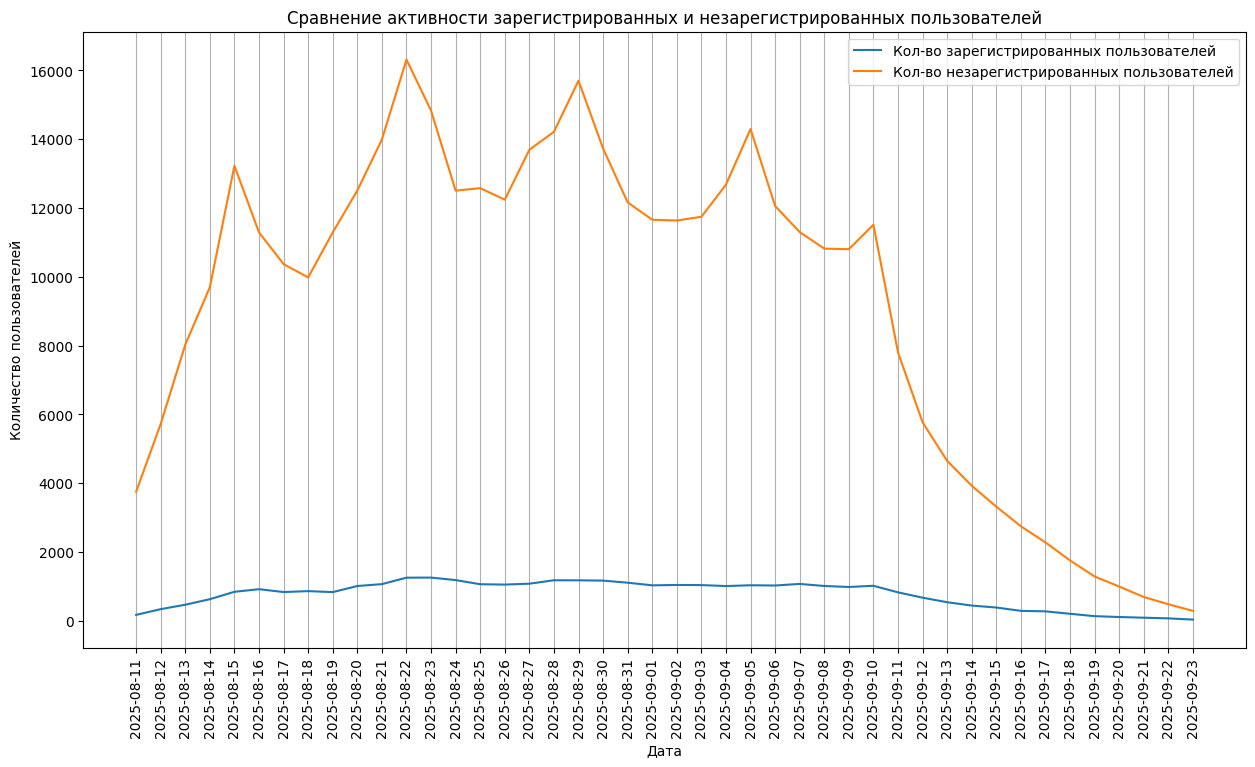

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(users_by_date_reg['session_date'], users_by_date_reg['user_id'], label ='Кол-во зарегистрированных пользователей')
plt.plot(users_by_date['session_date'], users_by_date['user_id'], label ='Кол-во незарегистрированных пользователей')

plt.xlabel("Дата")
plt.xticks(rotation=90)
plt.ylabel("Количество пользователей")
plt.legend()
plt.grid(True, axis='x')
plt.title('Сравнение активности зарегистрированных и незарегистрированных пользователей')
plt.show()

Активность зарегистрированных пользователей остается равномерной в течении всего периода, в то время как активность незарегистрированных пользователей проходит через цикл: на протяжении недели количество пользователей резко растет, достигая пика в пятницу, затем в течении недели активность резко падает, и такой цикл повторяется на протяжении месяца, до 10-го сентября. 10-го сентября количество незарегистрированных активных пользователей начинает падать, пока не достигает количества активных зарегистрированных пользователей.

In [7]:
users_by_date['share'] = users_by_date_reg['user_id'] / users_by_date['user_id']

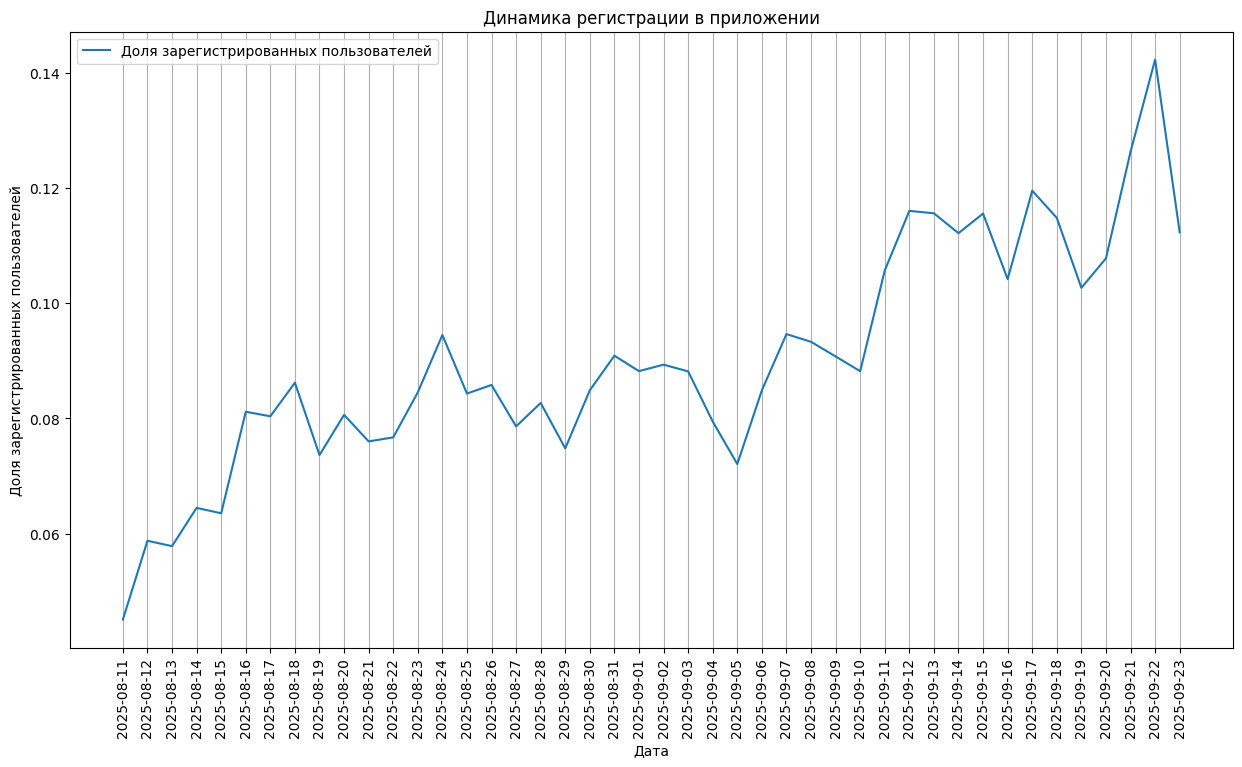

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(users_by_date['session_date'], users_by_date['share'], label ='Доля зарегистрированных пользователей')

plt.xlabel("Дата")
plt.xticks(rotation=90)
plt.ylabel("Доля зарегистрированных пользователей")
plt.legend()
plt.grid(True, axis='x')
plt.title('Динамика регистрации в приложении')
plt.show()

Доля зарегистрированных пользователей растет до 18-го августа, достигая около 8.5%. Примерно на этой отметки она держится до начала сентября. 5-го сентября наблюдается небольшое падение, а далее большой рост. Доля зарегистрированных достигает пика 22-го сентября и составляет около 14%.

### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

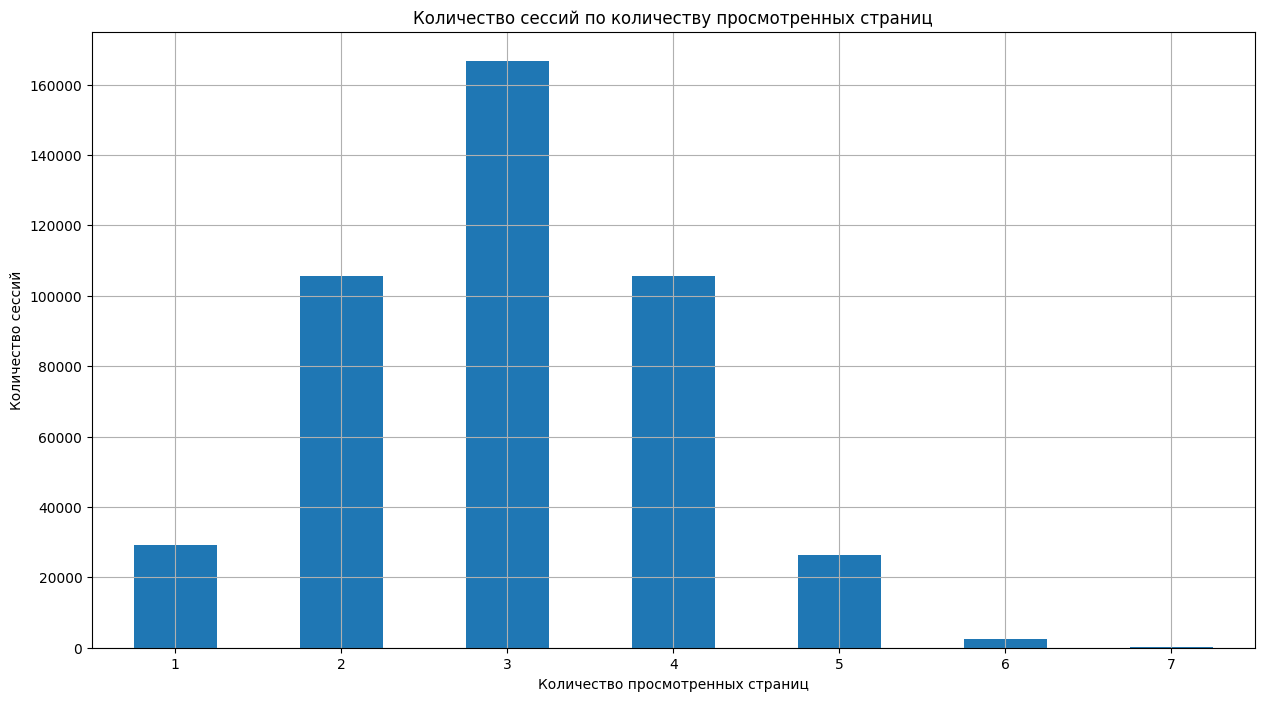

In [9]:
sessions_by_page = sessions_history_df[['session_id', 'page_counter']].groupby('page_counter')['session_id'].count()

sessions_by_page.plot(kind='bar',
                title='Количество сессий по количеству просмотренных страниц',
                legend=False,
                rot=0,
                figsize=(15, 8))

plt.grid()
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.show()

Чаще всего пользователи просматривают 3 страницы - 166690 сессий. Далее на 2-ом и 3-м месте идут сессии с просмотром 2 и 4 страниц - 105536 и 105569 соответственно. Минимальное количество сессий с 7-ю просмотренными страницами - всего 92.

### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [10]:
def session_category(row):
    page_count = row['page_counter']
    if page_count >= 4:
        return 1
    else:
        return 0

sessions_history_df['good_session'] = sessions_history_df.apply(session_category, axis=1)

share_of_good_sessions_by_date = sessions_history_df.groupby('session_date')['good_session'].mean().reset_index()

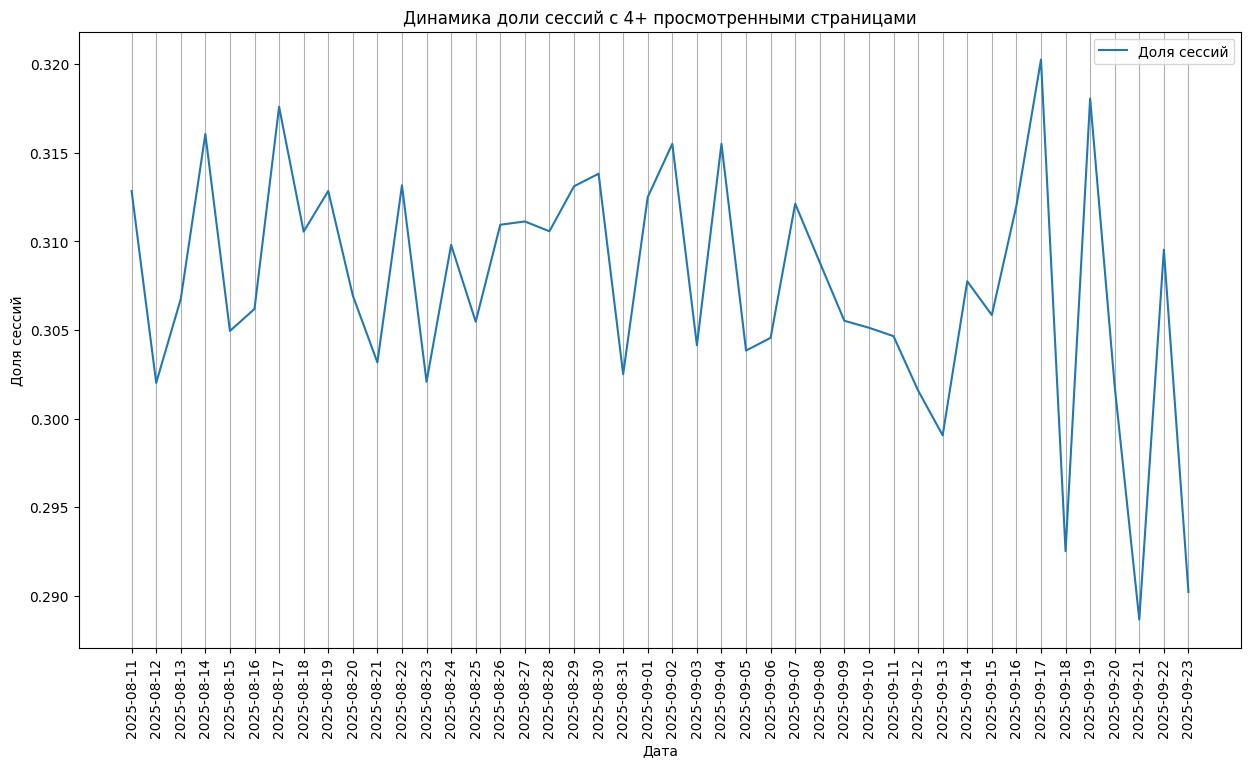

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(share_of_good_sessions_by_date['session_date'], share_of_good_sessions_by_date['good_session'], label ='Доля сессий')

plt.xlabel("Дата")
plt.xticks(rotation=90)
plt.ylabel("Доля сессий")
plt.legend()
plt.grid(True, axis='x')
plt.title('Динамика доли сессий с 4+ просмотренными страницами')
plt.show()

Динамика доли сессий с 4+ просмотренными страницами идет относительно стабильно до 15-го сентября, оставаясь около 30-31%. Далее наблюдаются большие скачки, достигающие пика 16-го сентября - 32% и низа - 21-го сентября составляющего менее 29%.

## Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

### Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

Целевая метрика - доля `good_session` для пользователей с внедренным новым алгоритмом и без. При формировании гипотез мы будем учитывать изменение данной метрики.

Сформулируем нулевую и альтернативную гипотезы:

H0: Введения нового алгоритма рекомендаций не повлияет на долю `good_session`;

H1: Введение нового алгоритма рекомендаций повысит долю `good_session` на 3%.

### Расчёт размера выборки
Рассчитаем необходимое для эксперимента количество пользователей.

Для этого установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [12]:
# Рассчитываем среднюю долю good_session
p1 = round(sessions_history_df['good_session'].mean(), 1)

In [13]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 1 - 0.8  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = p1 # Базовый уровень доли (рассчитано выше)
mde = 0.03 * p # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [14]:
#from math import abs, ceil
from math import ceil, fabs

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history_df.groupby('session_date')['user_id'].nunique().mean())
  
# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


## Мониторинг А/В-теста

### Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [15]:
df_sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

df_sessions_test_groups = df_sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index()

users_A = df_sessions_test_groups[df_sessions_test_groups['test_group'] == 'A']['user_id'].iloc[0]
users_B = df_sessions_test_groups[df_sessions_test_groups['test_group'] == 'B']['user_id'].iloc[0]

P = round(100 * fabs(users_A - users_B) / users_A, 2)

print(f'Разница между группами составляет {P}%')

Разница между группами составляет 0.74%


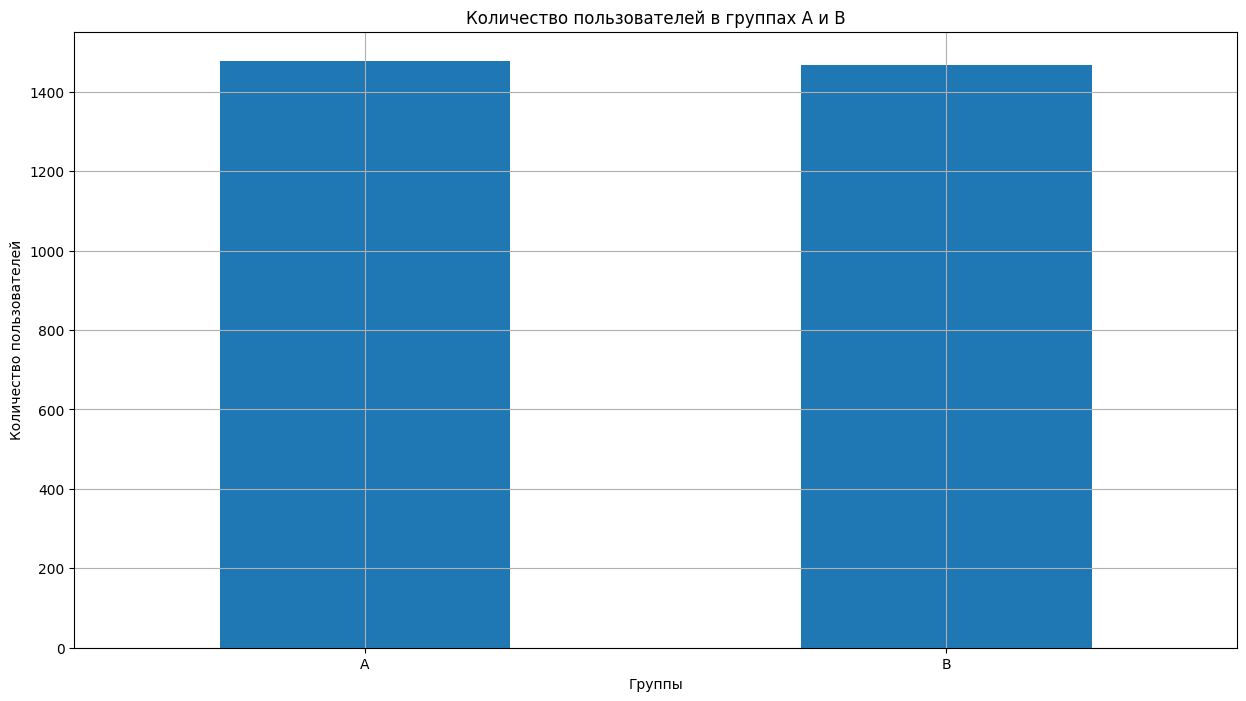

In [16]:
df_sessions_test_groups.plot(kind='bar',
                title='Количество пользователей в группах A и B',
                legend=False,
                rot=0,
                figsize=(15, 8))

plt.grid()
plt.xlabel('Группы')
plt.xticks(ticks=[0, 1], labels=['A', 'B'])
plt.ylabel('Количество пользователей')
plt.show()

Количество пользователей в группе A и B примерно одинаковое и составляет 1477 и 1466 человек соответственно.

### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [17]:
duplicates = df_sessions_test_part[['user_id', 'test_group']].drop_duplicates().groupby('user_id')['test_group'].count().sort_values(ascending=False)

display(duplicates)

user_id
00079359B9D3C6F7    1
ADC2E1E1158CFBB2    1
ADCEEDAD20F4782F    1
ADDCDDC883993FA6    1
AE072C4F9B473BCD    1
                   ..
54C3FA4C32B6ABBA    1
54F28A45A5E77DB8    1
54FF42B690A9B2E5    1
55529D5E3198D24D    1
FFFCDE7746148710    1
Name: test_group, Length: 2943, dtype: int64

Группы независимы, пересечений нет.

### Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

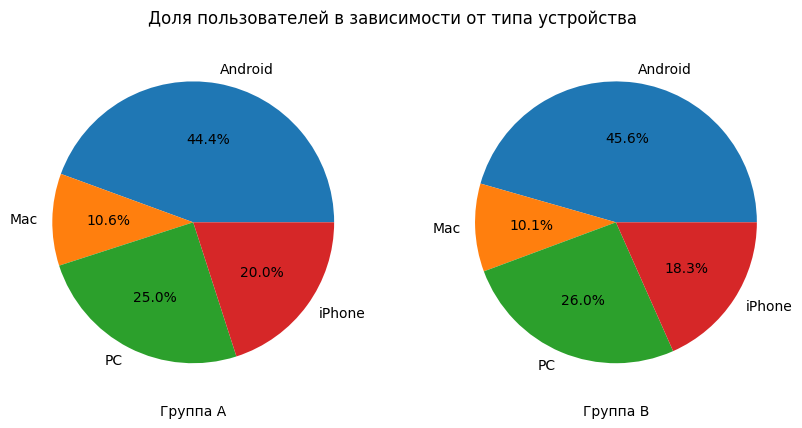

In [46]:
users_by_device_group_A = df_sessions_test_part[df_sessions_test_part['test_group']=='A'][['user_id', 'device']].drop_duplicates().groupby('device')['user_id'].count().reset_index()
users_by_device_group_B = df_sessions_test_part[df_sessions_test_part['test_group']=='B'][['user_id', 'device']].drop_duplicates().groupby('device')['user_id'].count().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.pie(users_by_device_group_A['user_id'], labels=users_by_device_group_A['device'], autopct='%1.1f%%')
ax2.pie(users_by_device_group_B['user_id'], labels=users_by_device_group_B['device'], autopct='%1.1f%%')

ax1.set_xlabel("Группа А")
ax2.set_xlabel("Группа B")
fig.suptitle('Доля пользователей в зависимости от типа устройства', y=0.85)
plt.show()

### Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

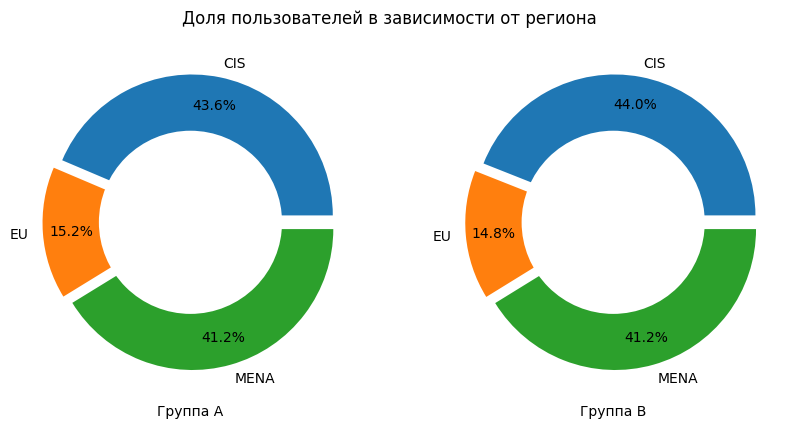

In [47]:
users_by_region_group_A = df_sessions_test_part[df_sessions_test_part['test_group']=='A'][['user_id', 'region']].drop_duplicates().groupby('region')['user_id'].count().reset_index()
users_by_region_group_B = df_sessions_test_part[df_sessions_test_part['test_group']=='B'][['user_id', 'region']].drop_duplicates().groupby('region')['user_id'].count().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
hole1 = plt.Circle((0, 0), 0.65, facecolor='white')
hole2 = plt.Circle((0, 0), 0.65, facecolor='white')

ax1.pie(users_by_region_group_A['user_id'], labels=users_by_region_group_A['region'], autopct='%1.1f%%', pctdistance=0.80, explode=[0.05, 0.05, 0.05])
ax1.add_artist(hole1)

ax2.pie(users_by_region_group_B['user_id'], labels=users_by_region_group_B['region'], autopct='%1.1f%%', pctdistance=0.80, explode=[0.05, 0.05, 0.05])
ax2.add_artist(hole2)

ax1.set_xlabel("Группа А")
ax2.set_xlabel("Группа B")
fig.suptitle('Доля пользователей в зависимости от региона', y=0.85)

plt.show()

### Вывод после проверки A/B-теста

Выводы сформулированные на основе проведённого анализа A/B-теста:

1) Было обнаружено незначительно различие между группами A и B. Оно составляет 0.74%.

2) Пересечение пользователей в выборках не было обнаружено.

3) Пользователи в группах A и B распределены примерно одинаково по категориям: устройства и регионы.

Итог: A/B-тест проходит корректно, нарушения не наблюдаются.

## Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

### Получение результатов теста и подсчёт основной метрики

- Сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [20]:
sessions_test_df = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

sessions_test_df['good_session'] = sessions_test_df.apply(session_category, axis=1)

### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будим сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведем на экран полученное значение p-value и интерпретируем его.

Гипотезы:

- Нулевая гипотеза H₀: Количество уникальных дневных сессий в группе A и B одинаково;
- Альтернативная гипотеза H₁: Количество уникальных дневных сессий в группе A и B имеют статистически значимое различие;

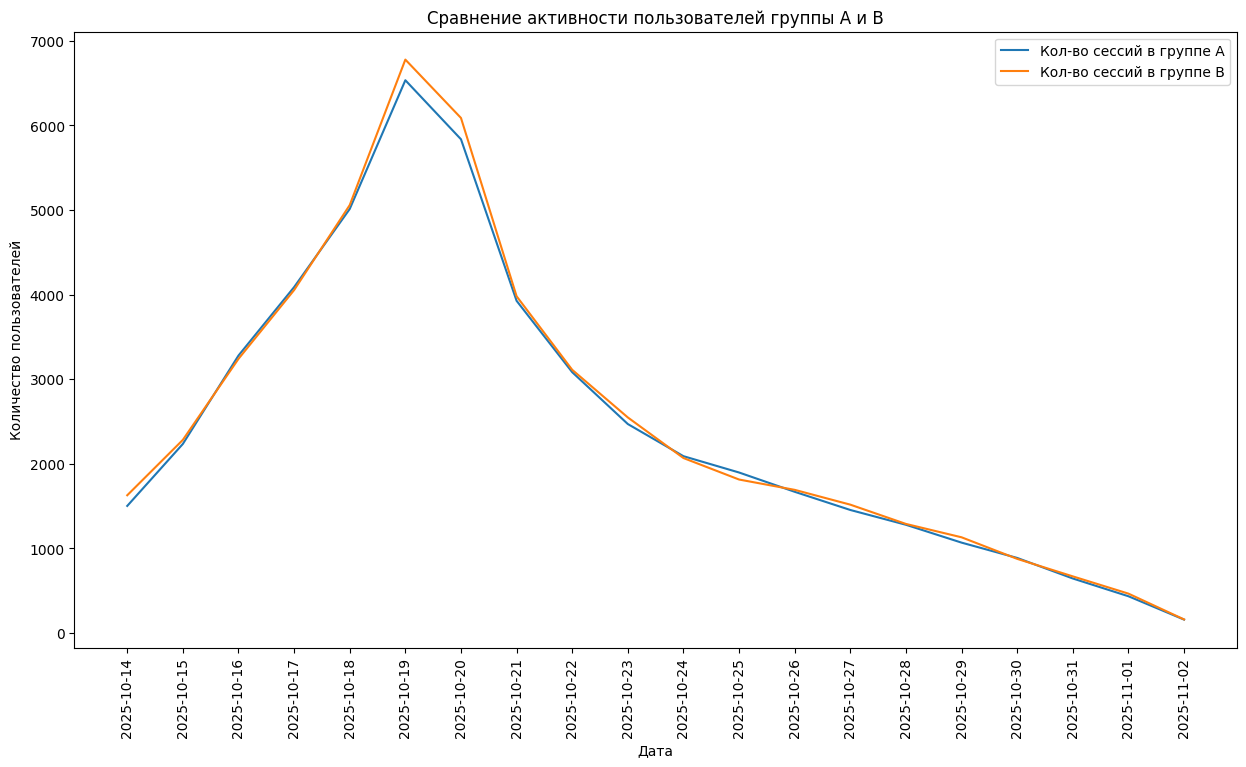

In [21]:
users_a_session_by_date = sessions_test_df[sessions_test_df['test_group']=='A'][['session_date', 'session_id']].groupby('session_date')['session_id'].nunique().reset_index()
users_b_session_by_date = sessions_test_df[sessions_test_df['test_group']=='B'][['session_date', 'session_id']].groupby('session_date')['session_id'].nunique().reset_index()

unique_date = users_a_session_by_date.session_date.unique()

plt.figure(figsize=(15, 8))
plt.plot(unique_date, users_a_session_by_date['session_id'], label ='Кол-во сессий в группе А')
plt.plot(unique_date, users_b_session_by_date['session_id'], label ='Кол-во сессий в группе B')

plt.xlabel("Дата")
plt.xticks(rotation=90)
plt.ylabel("Количество пользователей")
plt.legend()
plt.title('Сравнение активности пользователей группы A и B')
plt.show()

Сравнение динамики дневной активности групп A и B показало, что они очень похожи.

In [22]:
metric_a = users_a_session_by_date['session_id'] ## выборка целевой метрики для группы A
metric_b = users_b_session_by_date['session_id'] ## выборка целевой метрики для группы B

alpha = 0.05
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='two-sided'
)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента = {round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента = {round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Выборочные средние в группах A и B не равны')

p-value теста Стьюдента = 0.94
Нулевая гипотеза находит подтверждение!
Выборочные средние в группах A и B равны


### Сравнение доли успешных сессий

Когда мы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [23]:
good_session_share_by_group = sessions_test_df[['test_group', 'good_session']].groupby('test_group')['good_session'].mean().reset_index()

users_A_share = good_session_share_by_group[good_session_share_by_group['test_group'] == 'A']['good_session'].iloc[0]
users_B_share = good_session_share_by_group[good_session_share_by_group['test_group'] == 'B']['good_session'].iloc[0]

print(f'Средняя доля успешных сессий для группы A = {round(users_A_share, 2)}, средняя доля успешных сессий для группы B = {round(users_B_share, 2)}. Итого разница составляет: {round((users_B_share - users_A_share)*100, 2)}%')

Средняя доля успешных сессий для группы A = 0.31, средняя доля успешных сессий для группы B = 0.32. Итого разница составляет: 1.06%


### Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведем на экран полученное значение p-value и свои выводы о статистической значимости. Уровень значимости в эксперименте был выбран на уровне 0.05.

Так как будет использовать статистический Z-тест пропорций, для начала проверим, выполняется ли препосылка о достаточном количестве данных для проведения данного теста.

In [24]:
n_a, n_b = sessions_test_df[sessions_test_df.test_group == 'A'].shape[0], sessions_test_df[sessions_test_df.test_group == 'B']['good_session'].shape[0] ## размеры выборок A и B
m_a = sessions_test_df[sessions_test_df.test_group == 'A']['good_session'].sum() # количество успехов (регистраций) в группе A
m_b = sessions_test_df[sessions_test_df.test_group == 'B']['good_session'].sum()

p_a, p_b = m_a/n_a, m_b/n_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [25]:
stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger' # так как H_1: p_a < p_b
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпретация: новый алгоритм рекомендаций не увеличил количество просматриваемых страниц в рамках сессии')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпретация: новый алгоритм рекомендаций увеличил количество просматриваемых страниц в рамках сессии')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!
Интерпретация: новый алгоритм рекомендаций увеличил количество просматриваемых страниц в рамках сессии


### Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируем выводы для команды разработки приложения:

1) Был произведен эксперимент по введению нового алгоритма рекомендаций с целью выявления влияния на долю "хороших" сессий (4+ просмотренных страницы). Был рассчитан необходимый размер выборки для каждой группы: 3761 человека на группу. Пользователи были разделены примерно поровну на группы A и B: 1477 и 1466 соответственно. Длительность эксперимента - 20 дней.
2) Введение нового алгоритма увеличило долю "хороших" сессий на 1.06%.
3) p-value Z-теста пропорций = 0.0
4) Проведенный статистический анализ доказал позитивное влияние нового алгоритма рекомендаций. Рекомендовано внедрить нововведение.